### EJERCICIO 3 - AVANZADO

El fichero hr_train.cvs contiene una tabla sobre los empleados de una empresa. Entre otros incluye informacion de su nivel de satisfaccion, de la ultima evaluacion obtenida, del numero de proyecto en el que se encuentra, del numero medio de horas por semana, del numero de años que lleva en la compañia, si ha tenido o no un accidente en el trabajo, si se ha ido (left) de la compañia, si ha tenido una promocion en los ultimos 5 años, y por ultimo su nivel salarial (descrito como medio, alto o bajo) y el departamento en que se encuentra (sales/technnical ...)

El departamento de RRHH esta solicitando un clasificador que pueda predecir si alguien esta en riesgo de irse de la compañia para poder actuar  proactivamente. 

Notas:
- La columna "left" indica si alguien se ha ido de la compañia, es la "y" del problema y el objetivo de la prediccion.
- Las columnas "sales" y "salary" son alfanumericas. La mayoria de clasificadores (aunque no todos) no trabajn bien con este tipo de variables y requieren valores numericos. Dado el caso dispones de diferentes alternativas: (1) eliminar esas columnas y trabajar con el resto o (2) traducir esas columnas en columnas binarias - por ejemplo si "salary" tiene tres valores eliminar la columna original y sustituirla por tres columnas salary_low, salary_medium, salary_high donde se pondra un 1 en el tipo de salario y un 0 en las otras dos columnas restantes. Lo mismo para "sales", donde se transformara esa columna en tantas columnas como departamentos y un 1 en el departamento en que se encuentre el trabajador. Este es un preproceso muy tipico.


Nota de evaluacion:

En este ejercicio mas que el resultado final (que tambien) se evaluara los pasos y el razonamiento utilizado en cada decision que se toma para la implementacion del modelo. 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df=pd.read_csv('data/hr_train.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.42,0.46,2,150,3,0,1,0,sales,medium
1,0.66,0.77,2,171,2,0,0,0,technical,medium
2,0.55,0.49,5,240,3,0,0,0,technical,high
3,0.22,0.88,4,213,3,1,0,0,technical,medium
4,0.20,0.72,6,224,4,0,1,0,technical,medium


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10499 non-null  float64
 1   last_evaluation        10499 non-null  float64
 2   number_project         10499 non-null  int64  
 3   average_montly_hours   10499 non-null  int64  
 4   time_spend_company     10499 non-null  int64  
 5   Work_accident          10499 non-null  int64  
 6   left                   10499 non-null  int64  
 7   promotion_last_5years  10499 non-null  int64  
 8   sales                  10499 non-null  object 
 9   salary                 10499 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 820.4+ KB


In [4]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000,10499.000000
mean,0.612683,0.717131,3.808553,201.059815,3.494238,0.144299,0.292885,0.021716
std,0.248578,0.171483,1.230572,49.959332,1.453227,0.351410,0.455108,0.145763
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
df.salary.value_counts()

salary
low       5104
medium    4515
high       880
Name: count, dtype: int64

In [6]:
df.sales.value_counts()

sales
sales          2935
technical      1890
support        1556
IT              825
product_mng     639
marketing       614
hr              532
RandD           530
accounting      527
management      451
Name: count, dtype: int64

## Balance de Clases

Para iniciar con este ejercicio, empezaremos mirando como estan distribuidas las clases objetivo (Left), la cual representa si alguien se ha ido de la compañia, y en base a esto podemos empezar a trabajar en distintos modelos o tecnicas para balancear las clases en caso tal se encuentren desbalanceadas.

In [7]:
df.left.value_counts()

left
0    7424
1    3075
Name: count, dtype: int64

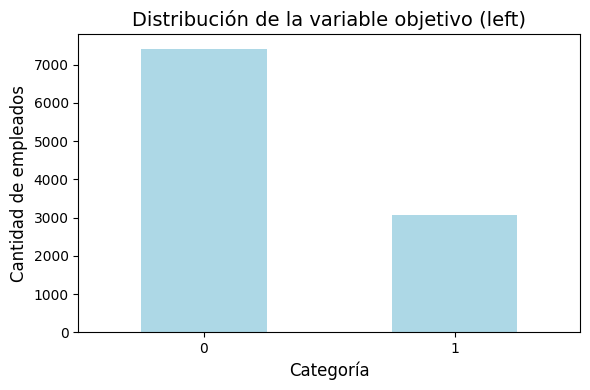

In [8]:
value_counts = df.left.value_counts()

plt.figure(figsize=(6, 4))
value_counts.plot(kind='bar', color='lightblue')
plt.title('Distribución de la variable objetivo (left)', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Cantidad de empleados', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Despues del pequeño analisis podemos concluir que: 
- Clase 0 (no se fue): 7424 empleados ≈ 71%
- Clase 1 (sí se fue): 3075 empleados ≈ 29%

A pesar de que no es un desbalance extremo, las clases si se encuentran un poco desbalanceadas, siendo lo suficientemente significativo como para afectar el rendimiento de los modelos, especialmente si usamos accuracy como métrica principal, es por ende, que usaremos usaremos: **Recall** ya que el obejtivo es detectar a los empleados en riesgo de irse. ademas de F1-score, para tener un balance entre ambas (accuracy y recall).

## Preprocesamiento de las variables categóricas

Pas columnas Sales y Salary lo mejor en este caso será aplicarles **One-Hot Encoding** en donde cada categoria se representaria como una columna binaria (0 o 1). De esta manera evitamos suposiciones erróneas de orden o magnitud, por ejemplo, los modelos pueden interpretar mal la relación (El modelo puede pensar que "high" es 2 veces más importante que "low", lo cual no es necesariamente cierto). ademas que cada modelo podrá aprender la relación entre esa categoría y la variable objetivo sin prejuicio por la creacion de "jerarquías" artificiales. De igual manera se preserva toda la información, es decir, la pérdida de esas columnas podría reducir la capacidad del modelo para capturar patrones relevantes, ademas de que, considero que eliminando estas dos columnas estariamos perdiendo mas de lo que podriamos ganar, por eso se tomará esta descicion.



In [9]:
df_encoded = pd.get_dummies(df, columns=["salary", "sales"], drop_first=False)

print("\nColumnas después del One-Hot Encoding:")
print(df_encoded.columns)


Columnas después del One-Hot Encoding:
Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical'],
      dtype='object')


In [10]:
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.42,0.46,2,150,3,0,1,0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,0.66,0.77,2,171,2,0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.55,0.49,5,240,3,0,0,0,True,False,...,False,False,False,False,False,False,False,False,False,True
3,0.22,0.88,4,213,3,1,0,0,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.20,0.72,6,224,4,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,True


In [11]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499 entries, 0 to 10498
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10499 non-null  float64
 1   last_evaluation        10499 non-null  float64
 2   number_project         10499 non-null  int64  
 3   average_montly_hours   10499 non-null  int64  
 4   time_spend_company     10499 non-null  int64  
 5   Work_accident          10499 non-null  int64  
 6   left                   10499 non-null  int64  
 7   promotion_last_5years  10499 non-null  int64  
 8   salary_high            10499 non-null  bool   
 9   salary_low             10499 non-null  bool   
 10  salary_medium          10499 non-null  bool   
 11  sales_IT               10499 non-null  bool   
 12  sales_RandD            10499 non-null  bool   
 13  sales_accounting       10499 non-null  bool   
 14  sales_hr               10499 non-null  bool   
 15  sa

### Validación de los resultados

- salary: ahora tenemos tres columnas (high, low, medium)

- sales: cada departamento se representa como una columna (IT, RandD, hr, etc)

**Nota:** ya que todas las columnas están codificadas como booleanas (True/False), la mayoria de los modelos no trabajan directamente con booleanos, asi que vamos a convertir esos valores a enteros 0 y 1.

In [12]:
df_encoded = df_encoded.astype({col: int for col in df_encoded.select_dtypes("bool").columns})

In [13]:
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.42,0.46,2,150,3,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.66,0.77,2,171,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.55,0.49,5,240,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.22,0.88,4,213,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.20,0.72,6,224,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Graficos que se utilizarán

In [14]:
def plot_confusion_matrix(y_test, y_pred, title="Matriz de Confusión"):
    labels=["Se queda", "Se va"]
    cf_mtx_rf = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx_rf, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_roc_curve(y_true, y_proba, title="Curva ROC"):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Separación de variables predictoras (X) y objetivo (y)

In [16]:
y = df_encoded["left"] # Variable objetivo

X = df_encoded.drop("left", axis=1) # Variables predictoras

### Division de los datos

Usaremos el stratify, debido a que preserva la proporción original de clases (left = 0 y left = 1) tanto en el conjunto de entrenamiento como en el de prueba, ya que existe un desbalance de clases. Si usamos un train_test_split sin stratify, podríamos acabar con un conjunto de entrenamiento que no representa bien el problema (por ejemplo, con muy pocos casos de empleados que se fueron).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Modelos

### Regresion Logistica 
El primer modelo que utilizaremos sea una regresion logistica simplemente como un avance rapadio, ya que es simple, rápido de entrenar y muy fácil de interpretar. Servirá como punto de comparación para modelos más complejos como Random Forest o MLP. Sera algo sencillo ya que no necesita grandes cantidades de ajuste ni una arquitectura complicada. Unicamente será de prueba

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [20]:
y_pred_lg = logreg.predict(X_test_scaled)
y_proba_lg = logreg.predict_proba(X_test_scaled)[:, 1]

In [21]:
print("Reporte de Clasificación Regresion Logistica:")
print(classification_report(y_test, y_pred_lg))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.68      0.74      1485
           1       0.46      0.66      0.54       615

    accuracy                           0.67      2100
   macro avg       0.64      0.67      0.64      2100
weighted avg       0.72      0.67      0.68      2100



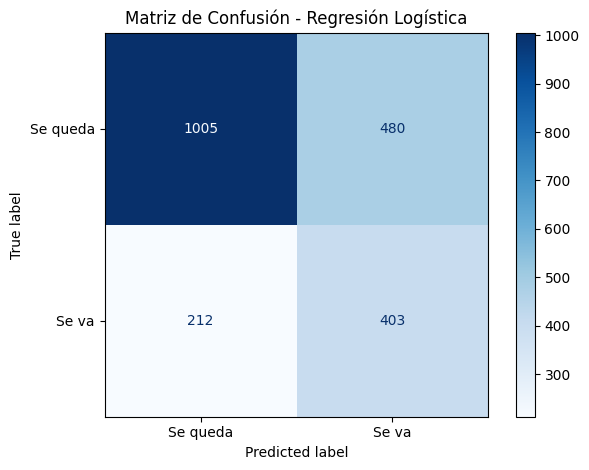

In [22]:
plot_confusion_matrix(y_test, y_pred_lg, title="Matriz de Confusión - Regresión Logística")

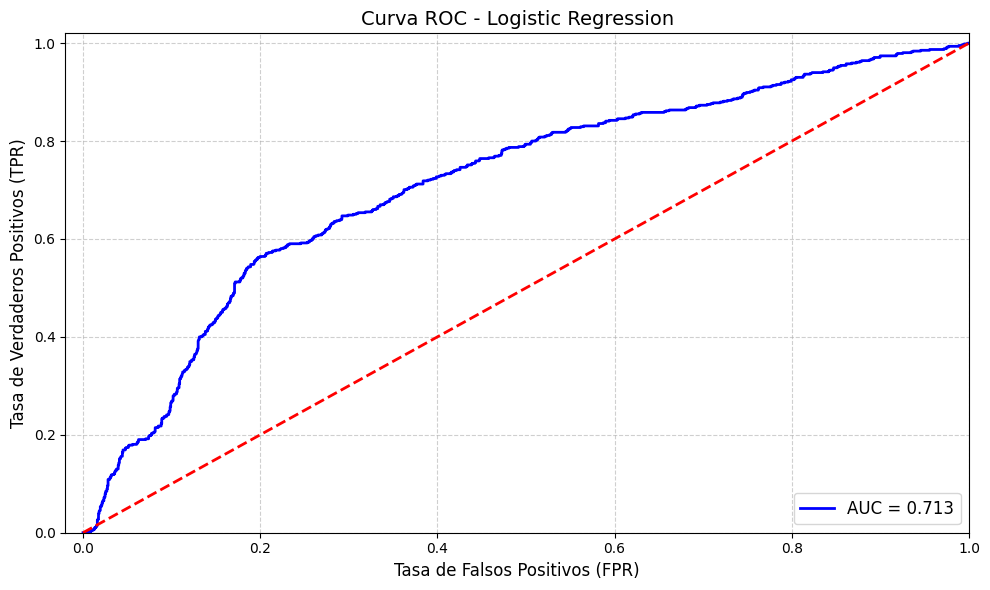

In [23]:
plot_roc_curve(y_test, y_proba_lg, title="Curva ROC - Logistic Regression")

In [24]:
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_lg)*100)

AUC-ROC Score: 71.307766006953


### Random Forest

In [25]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Para ROC AUC

In [26]:
print("Reporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["Se queda", "Se va"]))

Reporte de Clasificación:
              precision    recall  f1-score   support

    Se queda       0.87      0.96      0.91      1485
       Se va       0.86      0.64      0.73       615

    accuracy                           0.86      2100
   macro avg       0.86      0.80      0.82      2100
weighted avg       0.86      0.86      0.86      2100



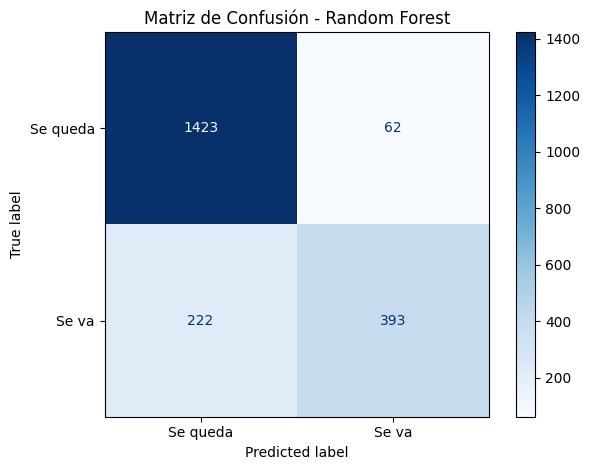

In [27]:
plot_confusion_matrix(y_test, y_pred_rf, title="Matriz de Confusión - Random Forest")

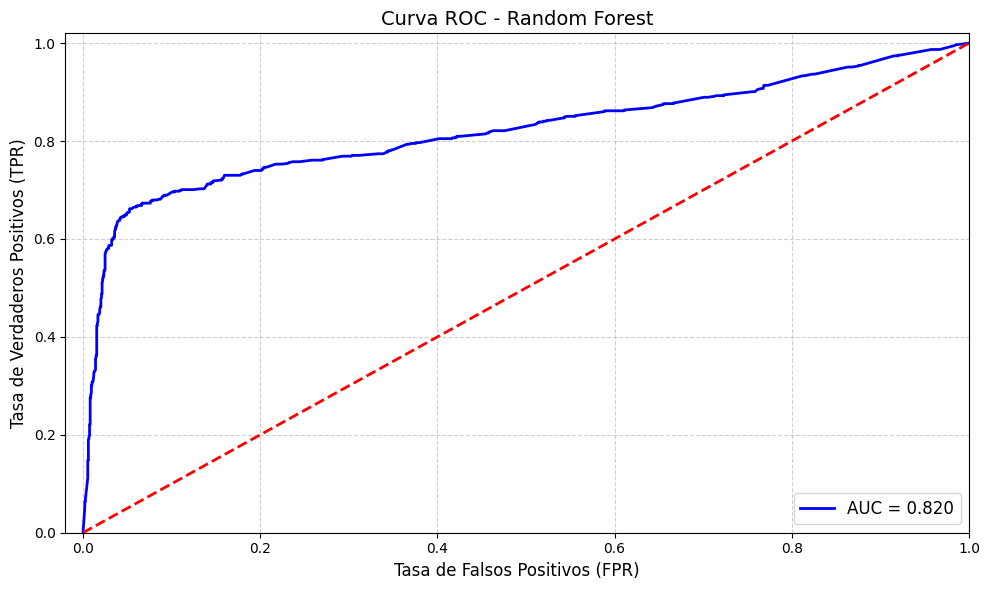

Roc-score: 82.01593167446826


In [28]:
plot_roc_curve(y_test, y_proba_rf, title="Curva ROC - Random Forest")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_rf)*100}")

### SVM

Excelente rendimiento en clases desbalanceadas(como es nuestro caso), usaremos SVM con class_weight='balanced' ya que esto ajusta automáticamente el peso de cada clase. Nos podra ser muy útil cuando queremos maximizar recall de la clase 1 (quien se va), lo cual es nuestro caso, ademas que, tras el One-Hot Encoding, ahora tenemos mas de 19 variables y sabemos que SVM trabaja muy bien en este tipo de entornos, especialmente con el kernel RBF (no lineal). Tambien con este kernel podemos capturar relaciones o patrones no lineales entre variables como:

- Satisfacción + carga de trabajo + departamento → riesgo de salida

En general, SVM  es un modelo indicado para este ejercicio ya que funciona muy bien para detectar patrones sutiles y no lineales, en este caso es ideal ya que necesitamos precisión y control en casos sensibles, en especial al decidir si un empleado se irá o no.

In [30]:
svm_model = SVC(kernel='rbf',class_weight='balanced',probability=True,random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [31]:
print("Reporte de Clasificación - SVM:")
print(classification_report(y_test, y_pred_svm, target_names=["Se queda", "Se va"]))

Reporte de Clasificación - SVM:
              precision    recall  f1-score   support

    Se queda       0.87      0.92      0.89      1485
       Se va       0.77      0.67      0.72       615

    accuracy                           0.84      2100
   macro avg       0.82      0.79      0.80      2100
weighted avg       0.84      0.84      0.84      2100



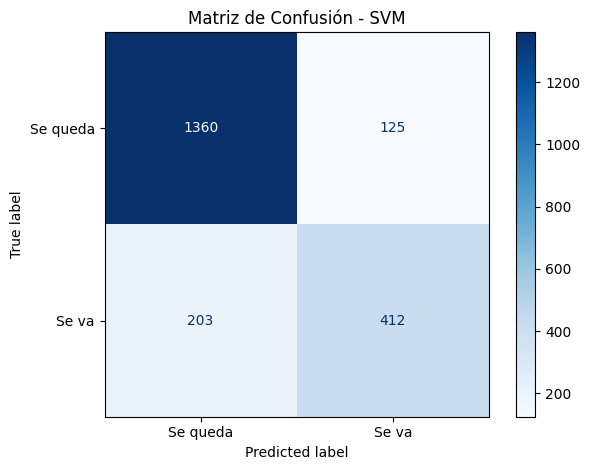

In [32]:
plot_confusion_matrix(y_test, y_pred_svm, title="Matriz de Confusión - SVM")

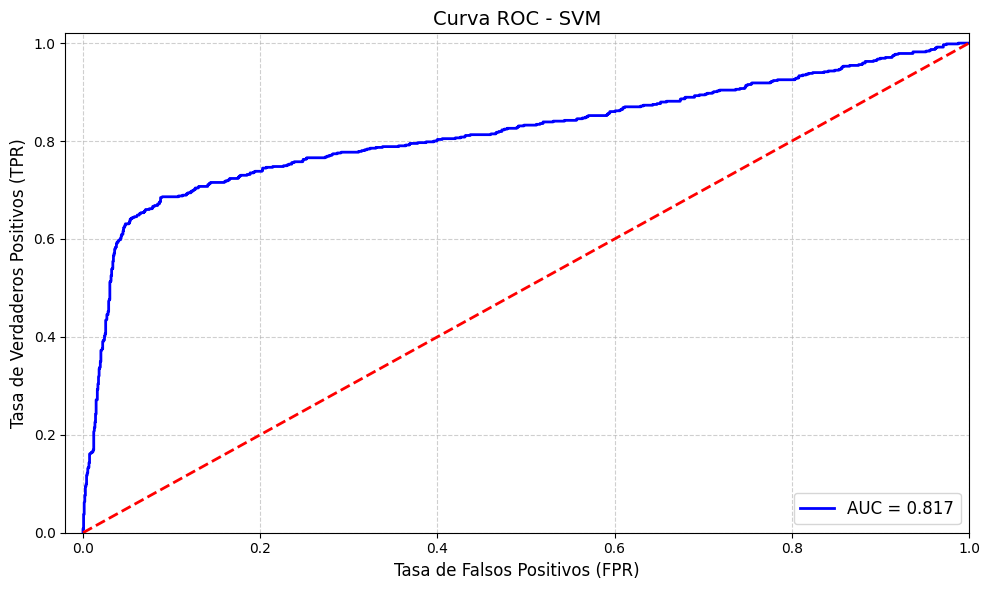

Roc-score: 81.70299197941475


In [33]:
plot_roc_curve(y_test, y_proba_svm, title="Curva ROC - SVM")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_svm)*100}")

### MLP

Tambien usaremos un MLP ya que estos modelos aprenden relaciones complejas y no lineales a diferencia de modelos como regresión logística, un MLP puede aprender funciones altamente no lineales. Tambien que captura interacciones ocultas entre variables, como combinaciones entre satisfacción, número de proyectos, horas y salario. Ademas de la gran flexibilidad de este tiene, ya que permite modificar sus hiperparametros, esto permite afinar el modelo según el comportamiento real en base a los datos. En resumen esperemos que el MLP sea una buena opción para que pueda modelar el problema problema, ya que como lo dije anteriormente, este puede beneficiarse de alta capacidad de representación y flexibilidad en el modelado. Tambien se utilizará la tecnica de GridSearchCV. Con el fin explorar diferentes numeros de neuronas en cada capa. En este ejemplo voy a evaluar diversas configuraciones con el fin de encontrar la mejor, y se utilizarán 10 folds para la validacion cruzada.

In [34]:
param_grid = {
    "hidden_layer_sizes": [
        (5,),       
        (10,),       
        (15,),       
        (5, 5),     
        (10, 5),
        (10, 10),
        (20, 20),
        (30, 30),
        (50, 50),
        (100, 100),
        (50, 25),  
        (100, 50),
        (30, 20),
        (20, 10)
    ]
}

In [35]:
mlp = MLPClassifier(max_iter=10000, random_state=42)

In [36]:
grid_search_mlp = GridSearchCV(estimator=mlp,param_grid=param_grid,scoring='f1',cv=10,return_train_score=True,verbose=True,n_jobs=-1)

In [37]:
grid_search_mlp.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (5, 5),
                                                (10, 5), (10, 10), (20, 20),
                                                (30, 30), (50, 50), (100, 100),
                                                (50, 25), (100, 50), (30, 20),
                                                (20, 10)]},
             return_train_score=True, scoring='f1', verbose=True)

In [38]:
results_mlp = pd.DataFrame(grid_search_mlp.cv_results_)
print(results_mlp[['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']])

   param_hidden_layer_sizes  mean_test_score  std_test_score
0                      (5,)         0.722291        0.019211
1                     (10,)         0.734637        0.021294
2                     (15,)         0.732477        0.019537
3                    (5, 5)         0.734037        0.016706
4                   (10, 5)         0.735399        0.022114
5                  (10, 10)         0.738345        0.022502
6                  (20, 20)         0.726084        0.021187
7                  (30, 30)         0.725366        0.028312
8                  (50, 50)         0.711943        0.017577
9                (100, 100)         0.705463        0.024137
10                 (50, 25)         0.711651        0.027059
11                (100, 50)         0.696965        0.020455
12                 (30, 20)         0.722518        0.021643
13                 (20, 10)         0.719667        0.024373


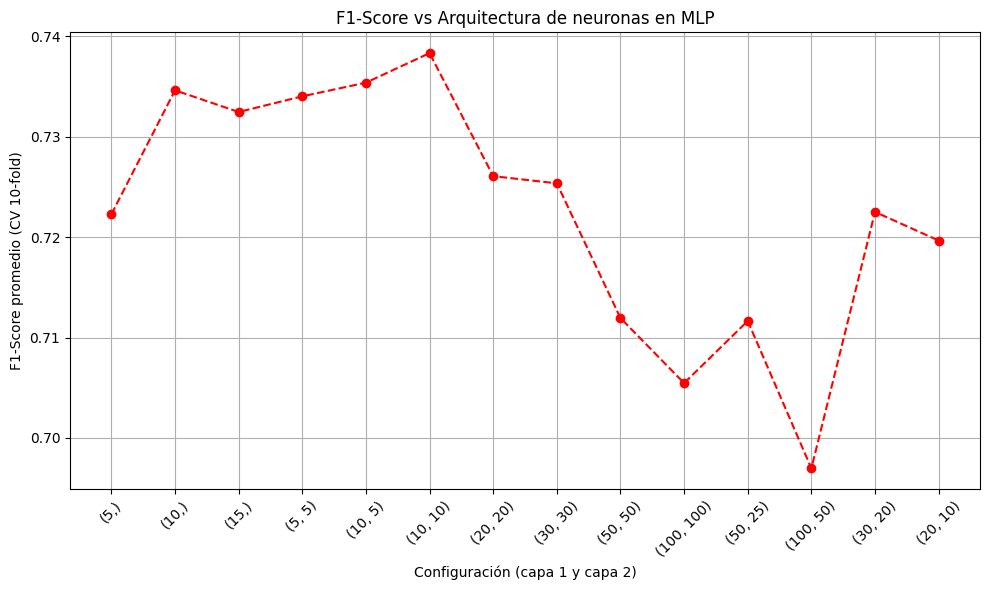

Mejor configuración: {'hidden_layer_sizes': (10, 10)}
Mejor F1-Score promedio: 0.7383447389820664


In [43]:
plt.figure(figsize=(10, 6))
plt.plot(results_mlp['param_hidden_layer_sizes'].astype(str),
         results_mlp['mean_test_score'], marker='o', linestyle='--', color='red')
plt.xlabel("Configuración (capa 1 y capa 2)")
plt.ylabel("F1-Score promedio (CV 10-fold)")
plt.title("F1-Score vs Arquitectura de neuronas en MLP")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Mejor resultado
print("Mejor configuración:", grid_search_mlp.best_params_)
print("Mejor F1-Score promedio:", grid_search_mlp.best_score_)

Listo, ahora que encontramos la mejor configuracion de arquitectura para la red, pasaremos a entrenarla y a evaluar sus metricas

In [44]:
final_mlp = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    max_iter=10000,
    random_state=42
)
final_mlp.fit(X_train_scaled, y_train)

y_pred_mlp = final_mlp.predict(X_test_scaled)
y_proba_mlp = final_mlp.predict_proba(X_test_scaled)[:, 1]

In [46]:
print("Reporte de Clasificación MLP:\n", classification_report(y_test, y_pred_mlp))

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      1485
           1       0.83      0.64      0.72       615

    accuracy                           0.85      2100
   macro avg       0.84      0.79      0.81      2100
weighted avg       0.85      0.85      0.85      2100



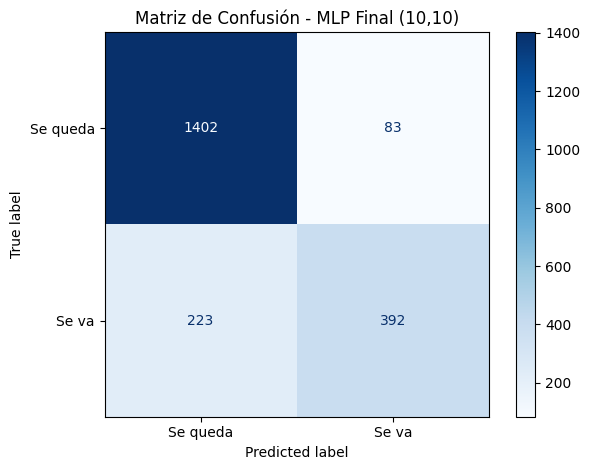

In [45]:
plot_confusion_matrix(y_test, y_pred_mlp, title="Matriz de Confusión - MLP Final (10,10)")

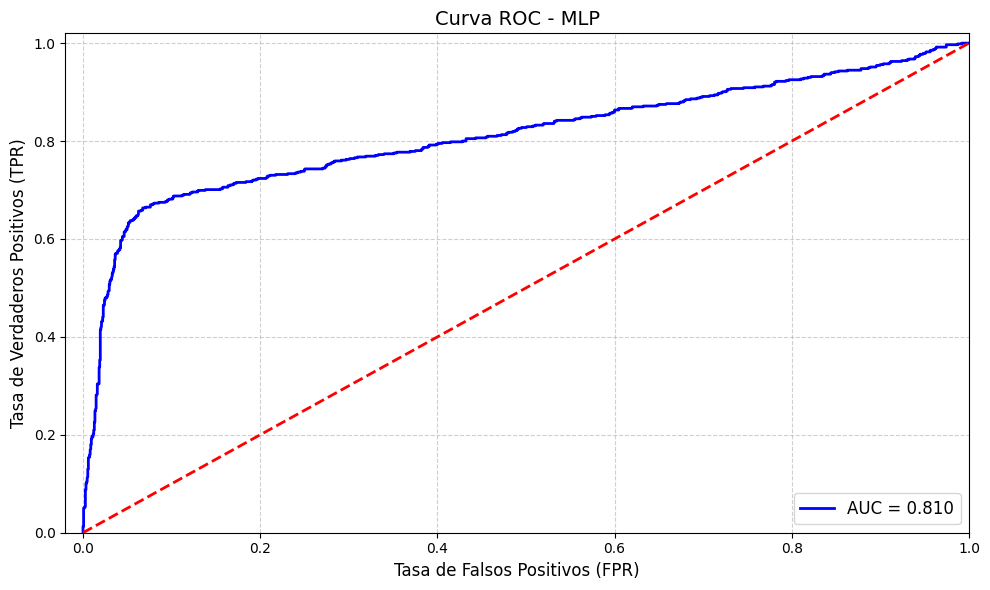

Roc-score: 81.03725602912594


In [47]:
plot_roc_curve(y_test, y_proba_mlp, title="Curva ROC - MLP")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_mlp)*100}")

In [83]:
param_grid = {
    'learning_rate': [ 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
}
gb_model = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    verbose=2,
    n_jobs=-1
)

In [84]:
grid_search_gb.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]},
             scoring='recall', verbose=2)

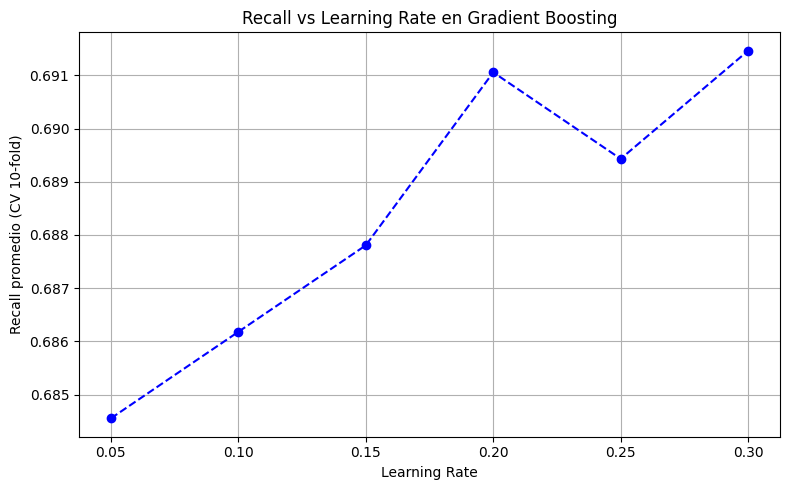

Mejor learning_rate: {'learning_rate': 0.3}
Mejor recall promedio: 0.6914634146341464


In [90]:
results_lr = pd.DataFrame(grid_search_gb.cv_results_)

plt.figure(figsize=(8, 5))
plt.plot(results_lr['param_learning_rate'], results_lr['mean_test_score'],
         marker='o', linestyle='--', color='blue')
plt.xlabel("Learning Rate")
plt.ylabel("Recall promedio (CV 10-fold)")
plt.title("Recall vs Learning Rate en Gradient Boosting")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Mejor learning_rate:", grid_search_gb.best_params_)
print("Mejor recall promedio:", grid_search_gb.best_score_)

In [91]:
final_gb = GradientBoostingClassifier(
    learning_rate=0.2,
    random_state=42
)
final_gb.fit(X_train, y_train)

y_pred_gb = final_gb.predict(X_test)
y_proba_gb = final_gb.predict_proba(X_test)[:, 1]

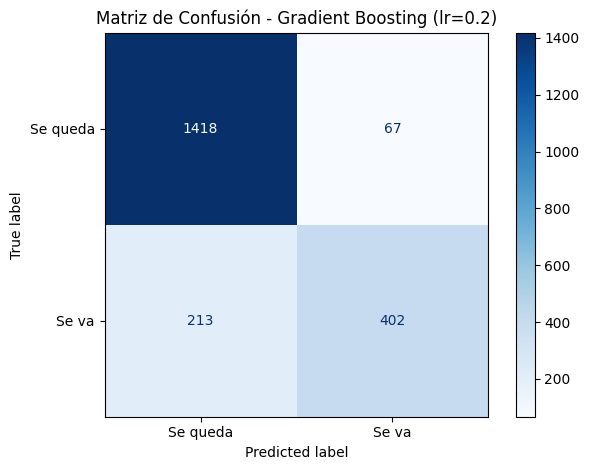

Reporte de Clasificación Gradient Boosting:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1485
           1       0.86      0.65      0.74       615

    accuracy                           0.87      2100
   macro avg       0.86      0.80      0.83      2100
weighted avg       0.87      0.87      0.86      2100

AUC-ROC Score: 0.8242095754290877


In [92]:
plot_confusion_matrix(y_test, y_pred_gb, title="Matriz de Confusión - Gradient Boosting (lr=0.2)")

print("Reporte de Clasificación Gradient Boosting:\n", classification_report(y_test, y_pred_gb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_gb))

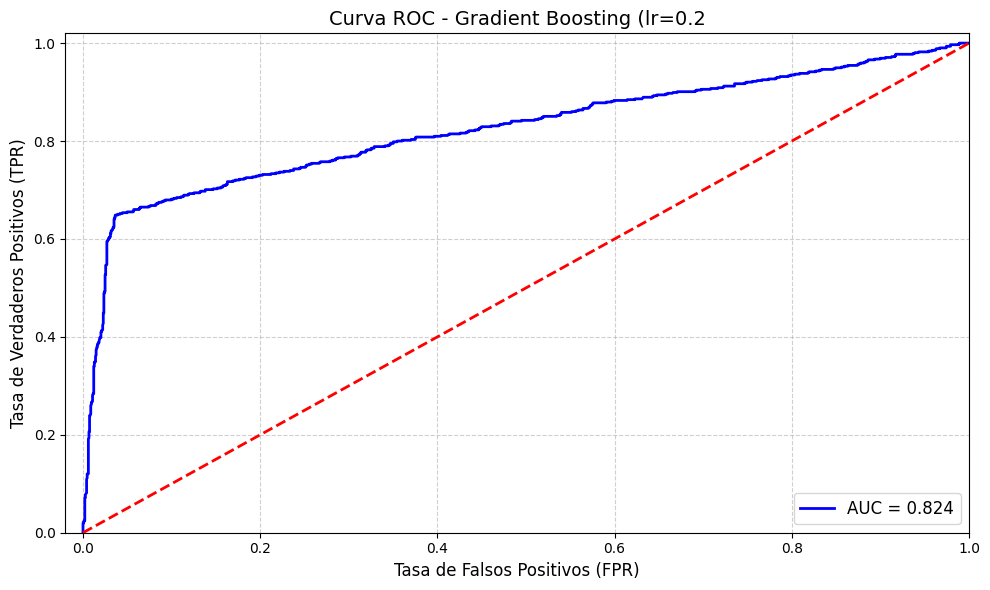

Roc-score: 82.42095754290877


In [95]:
plot_roc_curve(y_test, y_proba_gb, title="Curva ROC - Gradient Boosting (lr=0.2")
print(f"Roc-score: {roc_auc_score(y_test, y_proba_gb)*100}")